# Kaggle Competition: Natural Language Processing with Disaster Tweets


## Description of the Problem and Data
Briefly describe the challenge problem and NLP.  Describe the size, dimension, structure, etc., of the data.

In [1]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
from urllib.parse import unquote
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

### Problem
(from Kaggle) Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

Natural Language Processing - NLP enables computers to understand, interpret, and generate human language.  Key aspects include: Understanding context and meaning, processing text and speech, and enabling technologies for use in applications, like machine translation or voice assistants.  

Sources for NLP techniques: NLTK, tensorflow, keras, and sklearn documentation. Reddit r/NLP.   

### Data
Each sample in the train and test set has the following information: The text of a tweet, a keyword from that tweet (watch for blanks!), and the location the tweet was sent from (also could be missing).

We are predicting whether a given tweet is about a real disaster or not.  If so, predict a '1', otherwise '0'.

Columns: 'id', 'text', 'location', 'keyword', 'target' (in train.csv only, this denotes whether a tweet is about a real disaster or not).

In [2]:
# load the training dataset
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

In [3]:
# Describe the data size, dimension, structure, etc...
print(f"Dimensions (Rows, Columns): {df_train.shape}")
print(f"Total elements: {df_train.size}")

df_train.info()
print("\nData Types per Column:\n", df_train.dtypes)
print("\nFirst 3 rows:\n", df_train.head(3))

# Check for missing values (hinted at in problem description)
print("\nMissing values per column:\n", df_train.isnull().sum())

Dimensions (Rows, Columns): (7613, 5)
Total elements: 38065
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

Data Types per Column:
 id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

First 3 rows:
    id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   

   target  
0       1  
1       1  
2       1  

Missing 

## Exploratory Data Analysis
Show a few visualizations.  Describe any data cleaning procedures.  Based on this EDA, what is the plan of analysis?

'keyword' is missing 61 values.  This represents a small fraction of the data so I think that just deleting the rows
 will be the best option.  This will have a negligible impact on the model's training. 

In [4]:
# Handle missing values from 'keyword'
df_train.dropna(subset=['keyword'], inplace=True)
print(f"New training dataframe shape after dropping missing rows: {df_train.shape}")

New training dataframe shape after dropping missing rows: (7552, 5)


After accounting for the missing values in 'keyword', 'location' has 2472 missing values.  This is a large percentage of the data so I do not just want to delete it.  I'll replace the na's with a 'NONE_PROVIDED' to give them their own category and we can potentially check if this category has any predictive value.

In [5]:
# Handle missing values from 'location'
df_train['location'] = df_train['location'].fillna('NONE_PROVIDED')
print("Missing 'location' values imputed with 'NONE_PROVIDED'.")

Missing 'location' values imputed with 'NONE_PROVIDED'.


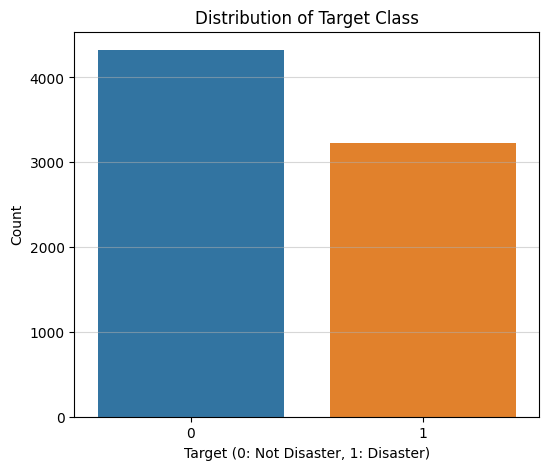

In [6]:
# Check the balance of the target classes using a count plot
plt.figure(figsize=(6,5))
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Target Class')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.xticks([0,1])
plt.grid(axis='y', alpha = 0.5)
plt.show()

### Text Cleaning and Normalization
Remove/replace elements that are typically irrelevant to the text's meaning.  HTML tags, URLs, Hashtags, Mentions, and Punctuation.

Standardize the remaining text.  Lowercasing, tokenization (splitting text into individual words/sub-words), Stop Word removal, and Lemmatize (reduce to base form of word).

In [7]:
# Preprocessing Function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # HTML tags
    text = re.sub(r'<.*?>', '', text)
    # URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Mentions and Hashtags
    text = re.sub(r'@\w+|#', '', text)
    # Punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Stop Word removal and lemmatize
    processed_tokens = []
    for word in tokens:
        if word not in stop_words:
            processed_tokens.append(lemmatizer.lemmatize(word))

    return " ".join(processed_tokens)

In [8]:
# Apply preprocessing to 'text' column
df_train['clean_text'] = df_train['text'].apply(preprocess_text)

print("Text column ('text') has been cleaned and normalized into 'clean_text'.")
print("\nExample Original vs. Cleaned Text:")
print(f"Original: {df_train['text'].iloc[0]}")
print(f"Cleaned:  {df_train['clean_text'].iloc[0]}")

Text column ('text') has been cleaned and normalized into 'clean_text'.

Example Original vs. Cleaned Text:
Original: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
Cleaned:  wholesale market ablaze


### Preprocess 'keyword' Column
decode the URL encodings, aggregate low frequency keywords, One-hot encode

In [9]:
# apply unquote to keyword
df_train['clean_keyword'] = df_train['keyword'].apply(unquote)

In [10]:
# get counts of unique keywords
keyword_counts = df_train['clean_keyword'].value_counts()
unique_count = len(keyword_counts)

print(keyword_counts.head())
print("-" * 50)
print(keyword_counts.tail())
print("-" * 50)

print(f"The total number of unique keywords is: {unique_count}")

clean_keyword
fatalities    45
deluge        42
armageddon    42
sinking       41
damage        41
Name: count, dtype: int64
--------------------------------------------------
clean_keyword
forest fire            19
epicentre              12
threat                 11
inundation             10
radiation emergency     9
Name: count, dtype: int64
--------------------------------------------------
The total number of unique keywords is: 221


### Aggregate 'keyword'
Aggregating keywords into a 'top N' and 'other' category should help with training the model by reducing dimensionality and complexity by shrinking the number of features the model has to learn from the keyword column.  This should make a simpler, faster model with less risk of overfitting.  

In [11]:
# Aggregate low-frequency keywords
TOP_N = 75
keyword_counts = df_train['clean_keyword'].value_counts()
top_n_keywords = keyword_counts.nlargest(TOP_N).index.tolist()

df_train['agg_keyword'] = np.where(
    df_train['clean_keyword'].isin(top_n_keywords),
    df_train['clean_keyword'],
    'Other'
)

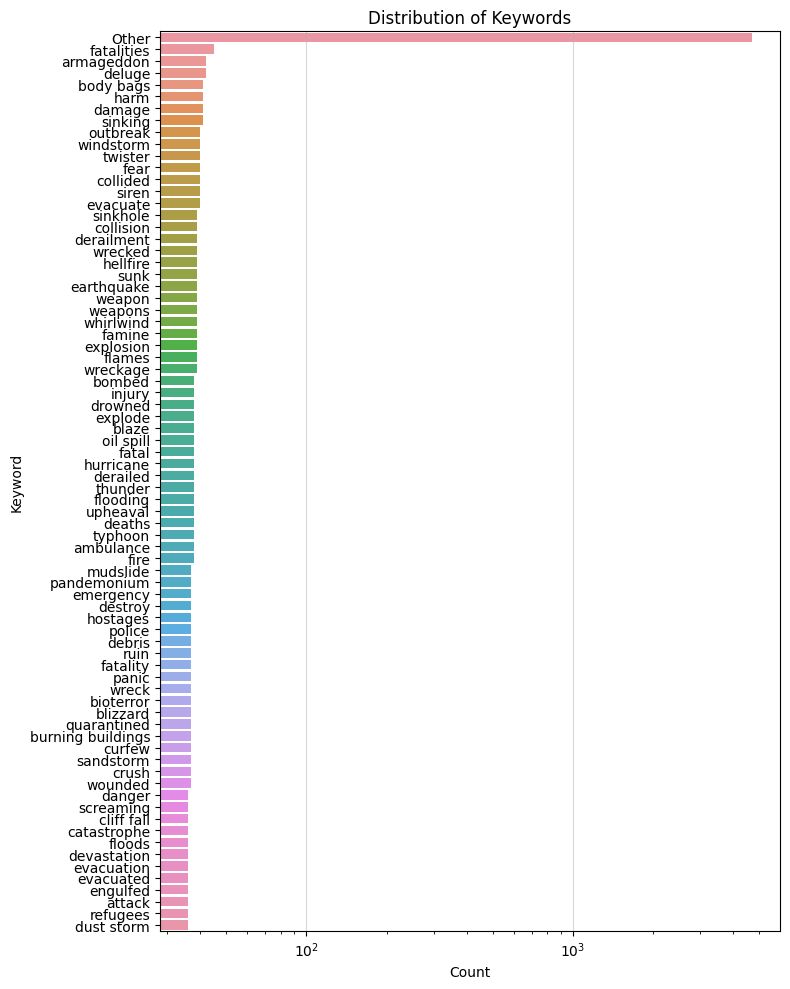

In [12]:
# Keyword Distribution
keyword_counts = df_train['agg_keyword'].value_counts().reset_index()
keyword_counts.columns = ['agg_keyword', 'count']
keyword_counts = keyword_counts.sort_values(by='count', ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(x='count', y='agg_keyword', data=keyword_counts)
plt.title('Distribution of Keywords')
plt.xlabel('Count')
plt.xscale('log')
plt.ylabel('Keyword')
plt.grid(axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
# One-hot encode 'agg_keyword' column
keyword_dummies = pd.get_dummies(df_train['agg_keyword'], prefix='keyword')

df_train = pd.concat([df_train, keyword_dummies], axis=1)

df_train.drop(['keyword', 'clean_keyword', 'agg_keyword'], axis=1, inplace=True)

In [14]:
print("New DataFrame Head (Showing New Keyword Columns)")
print(df_train.head())
print("\nNew DataFrame Shape")
print(f"The new shape (rows, columns) is: {df_train.shape}")

New DataFrame Head (Showing New Keyword Columns)
    id                       location  \
31  48                     Birmingham   
32  49  Est. September 2012 - Bristol   
33  50                         AFRICA   
34  52               Philadelphia, PA   
35  53                     London, UK   

                                                 text  target  \
31  @bbcmtd Wholesale Markets ablaze http://t.co/l...       1   
32  We always try to bring the heavy. #metal #RT h...       0   
33  #AFRICANBAZE: Breaking news:Nigeria flag set a...       1   
34                 Crying out for more! Set me ablaze       0   
35  On plus side LOOK AT THE SKY LAST NIGHT IT WAS...       0   

                                           clean_text  keyword_Other  \
31                            wholesale market ablaze           True   
32                    always try bring heavy metal rt           True   
33  africanbaze breaking newsnigeria flag set abla...           True   
34                       

### Preprocessing the 'location' column
There are significant data quality issues that need to be addressed before One-hot encoding.  

Aliases/Variants of locations like 'USA' and 'United States'.  Non-Locations like 'worldwide' and 'everywhere'.  Foreign Characters that need correction. and single occurances that I will group together as they are unlikely to be predictive.

In [15]:
# create function to accomplish preprocessing steps to 'location'
def clean_location(loc):
    if loc == 'NONE_PROVIDED':
        return loc
    try:
        loc = loc.encode('latin1').decode('utf8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        pass
        
    # lower case and strip whitespace
    loc = loc.lower().strip()
    
    # remove trailing punctuation
    loc = loc.strip(string.punctuation)
    
    # remove numbers and non-alphabetic noise
    loc = re.sub(r'[\d]', '', loc)
    loc = re.sub(r'[^\w\s,\-\']', '', loc)
    loc = re.sub(r'\s+', ' ', loc).strip() # replace multiple spaces

    return loc

In [16]:
# apply the clean_location function to the location column
df_train['clean_location'] = df_train['location'].apply(clean_location)

In [17]:
# create function to handle the noise and variation in the location column
def consolidate_location(loc):
    """Maps common noise terms and aliases to standard forms."""
    if loc in ['unknown', '']:
        return 'UNKNOWN'

    # Common Noise/Junk terms identified during inspection
    junk_list = ['worldwide', 'everywhere', 'here', 'the internet', 'my timeline', 
                 'noplace', 'follow me', 'he/him or she/her (ask)', 'email', 
                 'facebook', 'twitter', 'ig', 'snapchat', 'link in bio',
                'five down from the coffeeshop', 'reddit', 'road to the billionaires club',
                'all around the world', 'mad as hell', 'in the word of god',
                'narnia', 'planet earth', 'ìït ,', 'ìït ,-','happily married with kids',
                'america of founding fathers','taylor swift','theythem','anonymous','upstairs',
                ',','httpwwwamazoncomdpbhr','in the shadows','international','the world',
                'breaking news','in hell','pedophile hunting ground','neverland','world',
                'world wide'] # this list could go on forever.  stopping here.
    
    if any(j in loc for j in junk_list):
        return 'JUNK'

    # Consolidate country/city variations
    if loc in ['usa', 'united states', 'united states of america', 'us']:
        return 'usa'
    if loc in ['uk', 'london uk', 'england']:
        return 'united kingdom'
    if loc in ['new york', 'new york ny', 'ny', 'nyc']:
        return 'new york city'
    if loc in ['los angeles, ca', 'la']:
        return 'los angeles'
    if loc in ['ca', 'cali', 'california', 'southern california']:
        return 'california'
    if loc in ['texas', 'tx', 'republic of texas']:
        return 'texas'
    
    return loc

In [18]:
# apply consolidated mapping
df_train['standard_location'] = df_train['clean_location'].apply(consolidate_location)

In [19]:
# Aggregate low frequency locations
TOP_N_LOCATIONS = 200

location_counts = df_train['standard_location'].value_counts()
top_n_locations = location_counts.nlargest(TOP_N_LOCATIONS).index.tolist()

df_train['agg_location'] = np.where(
    df_train['standard_location'].isin(top_n_locations),
    df_train['standard_location'],
    'UNKNOWN'
)

In [20]:
final_unique_count = df_train['agg_location'].nunique()
print(f"\nAggregated to {final_unique_count} features.")
print(f"aggregated location feature unique counts:")
print(df_train['agg_location'].value_counts().head(5))

# Drop intermediate columns
df_train.drop(['location', 'clean_location', 'standard_location'], axis=1, inplace=True)

#print(df_train['agg_location'].unique().tolist())


Aggregated to 200 features.
aggregated location feature unique counts:
agg_location
NONE_PROVIDED    2472
JUNK             2201
UNKNOWN          1581
usa               173
new york city     110
Name: count, dtype: int64


In [21]:
location_dummies = pd.get_dummies(df_train['agg_location'], prefix='agg_location')

df_train = pd.concat([df_train, location_dummies], axis =1)

df_train.drop('agg_location', axis =1, inplace=True)

In [22]:
print("New DataFrame Head (Showing New Location Columns)")
print(df_train.head())
print("\nNew DataFrame Shape")
print(df_train.shape)

New DataFrame Head (Showing New Location Columns)
    id                                               text  target  \
31  48  @bbcmtd Wholesale Markets ablaze http://t.co/l...       1   
32  49  We always try to bring the heavy. #metal #RT h...       0   
33  50  #AFRICANBAZE: Breaking news:Nigeria flag set a...       1   
34  52                 Crying out for more! Set me ablaze       0   
35  53  On plus side LOOK AT THE SKY LAST NIGHT IT WAS...       0   

                                           clean_text  keyword_Other  \
31                            wholesale market ablaze           True   
32                    always try bring heavy metal rt           True   
33  africanbaze breaking newsnigeria flag set abla...           True   
34                                     cry set ablaze           True   
35               plus side look sky last night ablaze           True   

    keyword_ambulance  keyword_armageddon  keyword_attack  keyword_bioterror  \
31              False 

## Model Architecture and Training
Describe model architecture and reasoning for why it is suitable for this problem.  

Include reference list for NLP-specific tutorials/discussion boards/code examples.  Methods to process texts to matrix form include: TF-IDF, GloVe, Word2Vec, etc.  Briefly explain the method and how they work.  

Build and train a sequential neural network model (any RNN family nn, including advanced architectures LSTM, GRU, bidirectional RNN, etc).

### Text Vectorization and Word Embedding
There are two components we'll use to transform the text: Keras's Tokenizer to convert the text to a sequence of integers and a Keras embedding layer for processing the text.  

Keras's Tokenizer scans the entire 'clean_text', assigns a unique integer to every unique word, then converts each tweet into a sequence of those integers.

The Keras Embedding layer is initialized randomly and then learns a unique dense vector for every word in the vocabulary in training.  An advantage of this method vs GloVe or Word2Vec is that this process is simple and requires no external files.

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

2025-10-27 01:11:54.897991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761527515.157223      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761527515.229131      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
TEXT_COLUMN = 'clean_text'
TARGET_COLUMN = 'target'

categorical_cols = [col for col in df_train.columns if col.startswith('location_') or col.startswith('keyword_')]
X_cat = df_train[categorical_cols].values
Y = df_train[TARGET_COLUMN].values

MAX_WORDS = 10000  # Only consider the top 10,000 words
MAX_LEN = 50       # Pad/truncate sequences to a fixed length of 50

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train[TEXT_COLUMN])
word_index = tokenizer.word_index

# Convert text to sequences and pad them
sequences = tokenizer.texts_to_sequences(df_train[TEXT_COLUMN])
X_text = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Split the dataset into training and validation sets
X_text_train, X_text_val, X_cat_train, X_cat_val, Y_train, Y_val = train_test_split(
    X_text, X_cat, Y, test_size=0.2, random_state=0, stratify=Y
)

### Model Architecture
We're using a Bidirectional LSTM (Bi-LSTM) network.  

LSTMs are a type of RNN designed to overcome the vanishing gradient problem, making them excellent at learning long term dependencies in sequence data (like text).

Bidirectional LSTM means that the tweet is processed twice.  One time running from beginning to end, and another from the end to the beginning.  The outputs are combined.

For text classification, knowing the context that follows a word can be as important as the context that precedes it and this method attempts to capture that.

In [25]:
# Build the Bi-LSTM Model Architecture

EMBEDDING_DIM = 100
VOCAB_SIZE = min(len(word_index) + 1, MAX_WORDS)
NUM_CATEGORICAL_FEATURES = X_cat_train.shape[1] # Number of one-hot encoded features

# Text Input Branch (RNN)
text_input = tf.keras.Input(shape=(MAX_LEN,), name='text_input')
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(text_input)
x = Bidirectional(LSTM(64, return_sequences=False))(x) # 64 units, returns only the final output
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
text_output = x

# Categorical Input Branch (Dense Network)
cat_input = tf.keras.Input(shape=(NUM_CATEGORICAL_FEATURES,), name='cat_input')
y = Dense(16, activation='relu')(cat_input) # Simple dense layer for categorical features
cat_output = y

# Merge Branches
# Concatenate the output of the text branch and the categorical branch
merged = Concatenate()([text_output, cat_output])

# Final Output Layer
z = Dense(16, activation='relu')(merged)
z = Dropout(0.5)(z)
output = Dense(1, activation='sigmoid')(z) # Sigmoid for binary classification

# Create Model
model = tf.keras.Model(inputs=[text_input, cat_input], outputs=output)

2025-10-27 01:12:10.976020: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [26]:
# Hyperparameter Optimization & Training Setup

# Optimization: Using a learning rate scheduler and dropout
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # Start with a small learning rate

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks for improved training performance
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

print(model.summary())

# Train Model
history = model.fit(
     {'text_input': X_text_train, 'cat_input': X_cat_train},
     Y_train,
     epochs=20,
     batch_size=32,
     validation_data=({'text_input': X_text_val, 'cat_input': X_cat_val}, Y_val),
     callbacks=[early_stopping],
     verbose=1
 )

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 100)   │  1,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     84,480 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input           │ (None, 76)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      1,232 │ cat_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 48)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        784 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         17 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,090,641 (4.16 MB)

 Trainable params: 1,090,641 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.5654 - loss: 0.6867 - precision: 0.4742 - recall: 0.1249 - val_accuracy: 0.5725 - val_loss: 0.6770 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5662 - loss: 0.6773 - precision: 0.4819 - recall: 0.0538 - val_accuracy: 0.5804 - val_loss: 0.6511 - val_precision: 0.8750 - val_recall: 0.0217
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6347 - loss: 0.6430 - precision: 0.7221 - recall: 0.2070 - val_accuracy: 0.7545 - val_loss: 0.5693 - val_precision: 0.8873 - val_recall: 0.4876
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.7449 - loss: 0.5321 - precision: 0.8232 - recall: 0.5100 - val_accuracy: 0.8074 - val_loss: 0.4840 - val_precision: 0.8557 - val_recall: 0.6610
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8124 - loss: 0.4470 - precision: 0.8505 - recall: 0.6854 - val_accuracy: 0.

In [27]:
## Submission


## Result and Analysis
Hyperparameter tuning, compare different architectures, apply techniques to improve training/performance.  Include results with tables and figures.  Discuss why or why not things worked well, any troubleshooting, and hyperparameter optimization procedure summary.

### Results
Best Epoch = 6.  An accuracy of 81.3% suggests that the model is performing quite well at distinguishing between disaster and non-disaster tweets.  The difference between Precision (84.0%) and Recall (69.7%) indicates a slight bias.  The model correctly predicts a disaster 84% of the time, but misses about 30% of the actual disaster tweets (low recall).  

The F1 score is 2x(Precision * Recall)/(Precision + Recall) which is 76.2%.

### Analysis
We used a Bi-LSTM instead of a simpler RNN to improve sequence learning capacity.  We used Adam optimizer with a small initial learning rate (1e^-4) for slow, stable convergence.  Dropout (0.5) was applied after the main Bi-LSTM output and before the final dense layers to fight overfitting.  We used an Early Stopping callback to monitor the val_loss.  Training automatically stopped after the validation loss failed to improve for 5 consecutive epochs.  This technique is used to prevent overfitting (and speed things up).  

Submissions are evaluated using F1 between the predicted and expected answers.

## Discussion and Conclusion
Discuss and interpret results as well as learnings and takeaways.  What did and did not help improve the performance of the model(s)  What improvements could we try in the future?

### Areas for Improvement
The Bi-LSTM model might still struggle with stuble sarcasm or highly figurative language that is often found in social media.  

A pre-trained embedding like GloVe might have gave a better starting point, especially if many words in the test set were not present in the training set.  

The categorical dense layers were simple, more complex interactions could be learned by adding more layers to the categorical branch. 